# Fitting sum of exponentials
## Joseph Palmer
### Imperial College London & Royal Holloway University of London
### 05/06/2019
---

#### Background 
The exponential distribution takes the following forms:

\begin{equation}
\frac{1}{\lambda} e^{-\frac{\lambda}{x}}
\end{equation}
or:
\begin{equation}
\lambda e^{-\lambda x}
\end{equation}

These single exponentials can be combined in a sum to produce a sum of exponentials. Each individual exponential in the sum is mediated by a weighting factor $p$, which take the following constraints:

$0<p<1$
;
$0<\sum p<1$

The sum of exponentials allows different individual exponentials to model certain aspects of the data with the $p$ value acting as a switch to moderate their respective influence on the data.

The following shows the equation for a sum of 3 exponentials:

\begin{equation}
p_1\lambda_1 e^{-\lambda_1 x} + p_2\lambda_2 e^{-\lambda_2 x} + (1 - p_1 - p_2)\lambda_3 e^{-\lambda_3 x}
\end{equation}

This form is extendable through n:

\begin{equation}
\sum_{i}^{n-1}[p_i\lambda_i e^{-\lambda_i x}] + (1 - p_1 - p_2,..., p_n)\lambda_n e^{-\lambda_n x}
\end{equation}

#### Sampling
The sum of exponentials can be sampled from using the following routine: 

1) Make a list of rates and p values  
2) Sample each rate from the list using the associated paramater values.  
3) Draw a value from a expnential distribution with the sampled rate and append it to a list.

The following python function does this:

In [218]:
# set imports
import numpy as np
from scipy.optimize import minimize
import sympy
import warnings
import matplotlib.pyplot as plt
import pandas as pd

# Make warnings show as errors
warnings.filterwarnings("error")

# set seed on random number generator for demonstrating
np.random.seed(7)

In [219]:
# set seed on random number generator for demonstrating
np.random.seed(7)

def sample_sumexp(size, comb):
    selection = np.random.choice([i for i in comb.values()],
                                p = [i for i in comb.keys()],
                                size = size)
    sse = np.zeros(shape=(size, 1))
    for i in range(len(selection)):
        sse[i] = np.random.exponential(selection[i], 1)
    return sse

#### Optimization
The data can then be modeled using the sum of exponentials equation. First, we will set the rates to those used in sample_sumexp() (1.6, 1.11, 0.7) and try to numerically optomize the remaining p values. The optimizer used is from scipy.optimize.minimize and uses the fitting method [l-bfgs-b](https://en.wikipedia.org/wiki/Limited-memory_BFGS). The following functions build the required equation based on the number of rates wanted and minimizes the negative loglikelihood to return the most likely paramater values for the data and model.

In [220]:
# set seed on random number generator for demonstrating
np.random.seed(7)

def symbolise(eq, args):
    args_list = [None for i in range(len(args))]
    for i in range(len(args)):
        vars()[args[i]] = sympy.Symbol(args[i])
        args_list[i] = vars()[args[i]]
    symbol_args = tuple(i for i in args_list)
    return (eval(eq), symbol_args)

def build_equation(size):
    rates = ["r{}".format(i) for i in range(size)]
    probs = ["p{}".format(i) for i in range(size - 1)]
    sums = ["{p}*{r}*sympy.exp(-{r}*y)".format(p = probs[i],
        r = rates[i]) for i in range(size - 1)]
    last = "((1-{l})*{r})*sympy.exp(-{r}*y)".format(l = "-".join(probs),
            r = rates[-1])
    eq = "{}+{}".format("+".join(sums), last)
    args = (*rates, *probs, "y")
    return eq, args

def render(size, params, x):
    eq, args = symbolise(*build_equation(size))
    func = sympy.lambdify(args, eq)
    # fix rates
    pnumber = size - 1
    rates = [1.6, 1.11, 0.7]
    params = [*rates, *params]
    f_args = [*params, x]
    return func(*f_args)

def penalty(params):
    # impose penalty if the sum of paramaters is not between 0 and 1 and if 1 - sum
    # params is greater than 1 or less than 0
    if 1 - sum(params) > 1 or 1 - sum(params) < 0:
        return np.inf
    elif sum(params) > 1 or sum(params) < 0:
        return np.inf
    return False

def minimize_nll(params, x):
    size = 3
    cost = penalty(params)
    if cost:
        return cost
    loglike = sum(np.log(render(size, params, x)))
    return -loglike

def minimize_model(data, startest, bounds):
    kwargs = {"method" : "l-bfgs-b", "bounds" : bounds}
    args = (minimize_nll,
            startest,
            data)
    model = minimize(*args, **kwargs)
    return model

Using the functions defined above we will optimize the p values for a 3 rate sum of exponentials with rates 1.6, 1.11 and 0.7. 

The number of p values is equal to the number of rate values minus 1 (np = rates - 1) as the last p value is calculated from the other two values (1 - p1 - p2). The starting estimates used must sum to around 0.5 for the optimiser to be able to work effectivley. This is because the optimiser will try and change the values as much as it can in the initial itterations to see what the effects are. If the changes result in the p values exceding 1 then an infinate number is returned. Whilst this is effective at keeping the optimizer in check, at the initial stages it can prevent the paramaters from being optimise by convincing the optimizer that any change in the paramaters produces a lower likelihood. The solution is to vary the starting estimates so they can change without going outside of their bounds (0.5 and 0.1) and allow the optimizer space to explore. 

The bounds on the p values are: $0<p<1$ 

In [221]:
# set seed on random number generator for demonstrating
np.random.seed(7)

# Set the data size and dictionary or probabilities and rates for sumexp sampling
data_size = 10000
comb = {0.3:1.6,
        0.5:1.11,
        0.2:0.7}
in_wp = list(comb.keys())[:2]

# generate data from sum of exponentials function defined
simdata = sample_sumexp(data_size, comb)

# set size as number of rate values
size = 3

# starting estimates
startest = [0.3, 0.3]

# bounds
bounds = ((0, 1),) * (size -1)

# run the model
model = minimize_model(simdata, startest, bounds)
p3 = eval("1 - {}".format("-".join([str(i) for i in model.x])))
p1, p2 = [i for i in model.x]
optimized_vals = [p1, p2, p3]
print("-Model-\n{}\n\n"
      "- {} Simulations -\n"
      "Input p values     : {}\n"
      "Estimated p values : {}\n\n".format(model,
                                            data_size,
                                            list(comb.keys()),
                                            optimized_vals))

# see how loglikelihood compares to the actual paramaters used
actual_ll = minimize_nll(in_wp, simdata)
print("\nInput paramater likelihood = {}".format(actual_ll))

-Model-
      fun: array([11526.41869065])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00600267,  0.00345608])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 10
   status: 0
  success: True
        x: array([0.05278634, 0.41526517])

- 10000 Simulations -
Input p values     : [0.3, 0.5, 0.2]
Estimated p values : [0.052786340037275926, 0.41526517251654954, 0.5319484874461746]



Input paramater likelihood = [11786.80551512]


Over many simulations, the estimated values get closer to the actual values used in sampling. They will never exactly resemble them due to random variations in the sampling. As there is no analyitical solution to the sum of exponentials equation, this is the best way to check the routine is working effectivley.

#### Grid search sampling
Whilst the above shows the use of the optimizer it does not give us a visual representation of the paramater space. For more than 3 paramaters visualisation is not possible, but it can be used for a sum of 3 exponentials with fixed rates to show p1 against p2. This is done by taking a matrix of the paramater space as combinations of p1 and p2 and calculating the loglikelihood using the defined equation above. 

The following code does this to produce a contour plot of loglikelihood for values of p1 and p2.

In [222]:
# get data for contour plot
x = y = np.linspace(0, 1, 100)
ll = np.zeros((len(x), len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        ll[i][j] = -minimize_nll([x[i], y[j]], simdata)

<IPython.core.display.Javascript object>


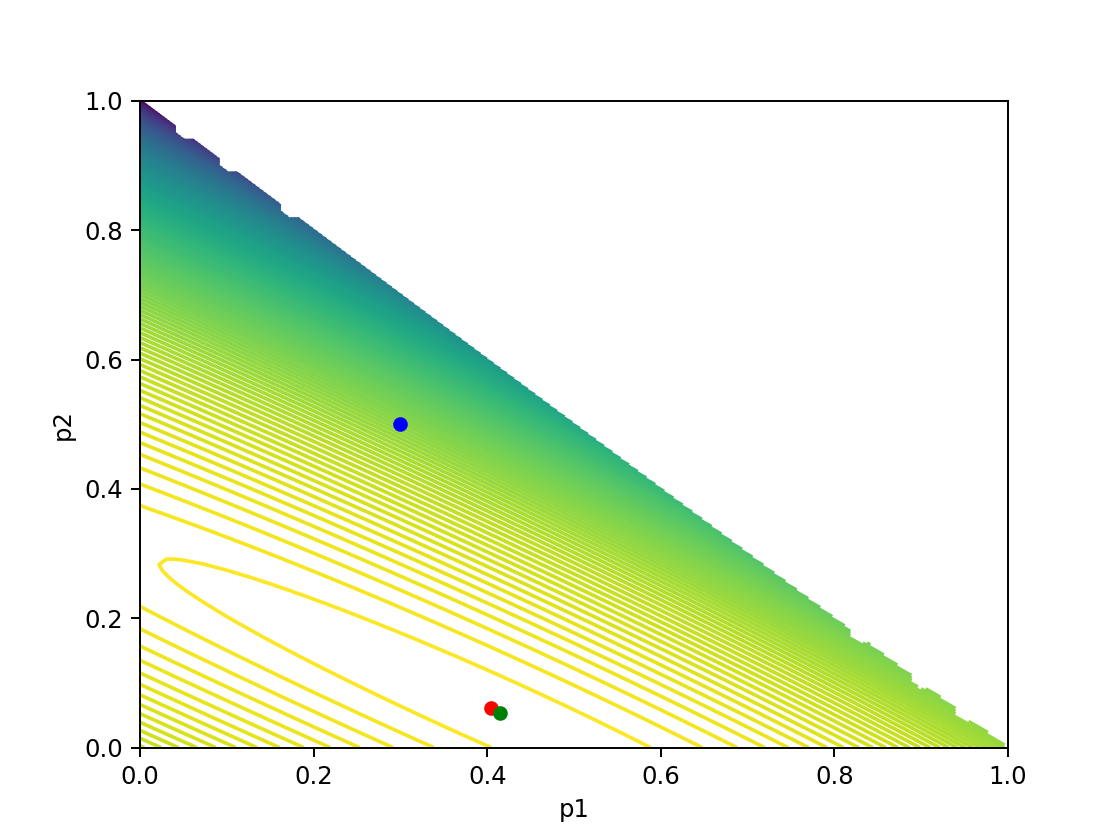

- Paramater values with best loglikelihood -
p1 = [0.4040404]
p2 = [0.06060606]
p3 = [0.53535354]
likelihood = -11526.429204929875


In [223]:
# make contour plot
fig = plt.figure()
plt.contour(x, y, ll, 200)
plt.xlabel("p1")
plt.ylabel("p2")

## retrieve position of highest likelihood and plot
max_ll_poss = np.where(ll==np.amax(ll))
max_x = x[max_ll_poss[1]]
max_y = y[max_ll_poss[0]]
plt.plot(max_x, max_y, color="red", marker = "o", markersize=5)

# place marker at actual input values
plt.plot(in_wp[0], in_wp[1], color="blue", marker = "o", markersize=5)

# place marker at optimized values
plt.plot(optimized_vals[1], optimized_vals[0], color="green", marker = "o", markersize=5)


# show plot
plt.show()

# show paramater values
print("- Paramater values with best loglikelihood -\n"
      "p1 = {}\n"
      "p2 = {}\n"
      "p3 = {}\n"
      "likelihood = {}".format(max_x, max_y, (1 - max_x - max_y), np.amax(ll)))

The contour plot above shows the highest likelihood (red marker) and the likelihood of the input paramaters for p1 & p2 (0.5, 0.3) (blue marker) and the likelihood of the optimizer (green marker). This shows visually the paramaters which give the best likelihood are different to those used as input. The paramaters and likelihood retreved from the grid search (0.40, 0.061, 0.54) are very close to those found by the optimizer (0.42, 0.053, 0.53) (differences likely due to reduced precision in the grid search as they return similar likelihoods), suggesting the optimizer is in fact finding the highest likelihood as designed.

The question is: Why do there exist paramaters that produce a higher likelihood than those used to create the data? The answer likely is due to the model fitting to random variations in the data; over fitting. How can this be tested?

Combined this shows the minimization routine is able to return the p weighting paramaters with the highest likelihood for a sum of exponential model with known rate values.

#### Sampling with unknown rate values

To try and maximise the rate values in addition to the p weights the functions specified above need to be modified to accept more paramaters.

In [230]:
# set seed on random number generator for demonstrating
np.random.seed(7)

def render(size, params, x):
    eq, args = symbolise(*build_equation(size))
    func = sympy.lambdify(args, eq)
    # fix rates
    pnumber = size - 1
    #rates = [1.6, 1.11, 0.7]
    #params = [*rates, *params]
    f_args = [*params, x]
    return func(*f_args)

def penalty(params):
    # impose penalty if the sum of paramaters is not between 0 and 1 and if 1 - sum
    # params is greater than 1 or less than 0
    pi = int(len(params) - np.ceil((len(params) / 2)))
    if 1 - sum(params[-pi:]) > 1 or 1 - sum(params[-pi:]) < 0:
        return np.inf
    elif sum(params[-pi:]) > 1 or sum(params[-pi:]) < 0:
        return np.inf
    return False

Now we can produce the same model but ask the minimizer to produce the rates as well.

In [231]:
# set seed on random number generator for demonstrating
np.random.seed(7)

# Set the data size and dictionary or probabilities and rates for sumexp sampling
data_size = 10000
comb = {0.3:1.6,
        0.5:1.11,
        0.2:0.7}

# generate data from sum of exponentials function defined
simdata = sample_sumexp(data_size, comb)

# set size as number of rate values
size = 3

# starting estimates
startest = [1.6, 1.11, 0.7, 0.3, 0.3]

# bounds (changed here to include rates)
bounds = (((0, None),) * size) + (((0, 1),) * (size -1))

# run the model
model = minimize_model(simdata, startest, bounds)
print(model)

pi = 2
pl = eval("1 - {}".format("-".join([str(i) for i in model.x[-pi:]])))
model_params = [i for i in model.x]
model_params.append(pl)
optimized_vals = model.x[-pi:]
print("\n- Input paramater values -")
print(list(comb.values()) + list(comb.keys()))
print("\n- Estimated paramater values -")
print(model_params)

# see how loglikelihood compares to the actual paramaters used
params = list(comb.values()) + list(comb.keys())[:2]
sim_rates = model.x[:3]
actual_ll = minimize_nll(params, simdata)
print("\nInput paramater likelihood = {}".format(actual_ll))

      fun: array([11525.69696736])
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.37988536, -20.5132892 , -39.00622687, -35.98524927,
       -22.80121407])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 156
      nit: 21
   status: 0
  success: True
        x: array([1.86345242, 0.94875358, 0.64539487, 0.07970101, 0.59656903])

- Input paramater values -
[1.6, 1.11, 0.7, 0.3, 0.5, 0.2]

- Estimated paramater values -
[1.8634524191762414, 0.9487535797768119, 0.6453948715965726, 0.07970100688529157, 0.5965690288136101, 0.32372996430109835]

Input paramater likelihood = [11786.80551512]


Some of the p weights here are close to the input values, but most of the paramaters otpimised are quite different to the values used in the sampling. A way to test this is to plot the likelihood curve like before, however, this is difficult to visualise with more than 3 paramaters.

It could also be that this combination of rate and p weightings is equivilent to the input values for rate and p weightings.

One way to test this is to plot the likelihood contour for p weights with the rate paramaters optimised fixed in the model to see if the p weights are the best for these rate values. Fist we need to reset the functions we previously changed.

In [232]:
# set seed on random number generator for demonstrating
np.random.seed(7)

def render(size, params, x):
    eq, args = symbolise(*build_equation(size))
    func = sympy.lambdify(args, eq)
    # fix rates
    pnumber = size - 1
    # rates changed here to what the function above returned
    rates = sim_rates
    params = [*rates, *params]
    f_args = [*params, x]
    return func(*f_args)

def penalty(params):
    # impose penalty if the sum of paramaters is not between 0 and 1 and if 1 - sum
    # params is greater than 1 or less than 0
    if 1 - sum(params) > 1 or 1 - sum(params) < 0:
        return np.inf
    elif sum(params) > 1 or sum(params) < 0:
        return np.inf
    return False

def minimize_nll(params, x):
    size = 3
    cost = penalty(params)
    if cost:
        return cost
    loglike = sum(np.log(render(size, params, x)))
    return -loglike

Now we can plot the likelihood contour just as before.

In [234]:
# set seed on random number generator for demonstrating
np.random.seed(7)

# get data for contour plot
x = y = np.linspace(0, 1, 100)
ll = np.zeros((len(x), len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        ll[i][j] = -minimize_nll([x[i], y[j]], simdata)

<IPython.core.display.Javascript object>


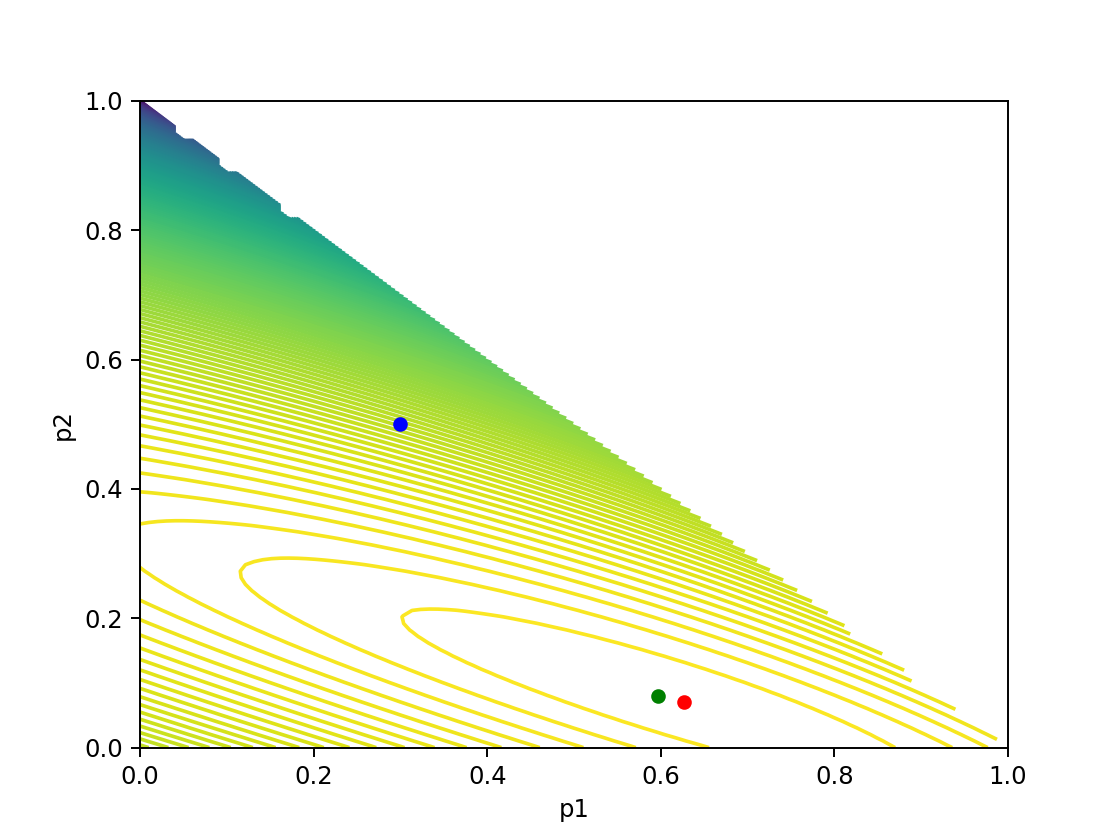

- Paramater values with best loglikelihood -
p1 = [0.62626263]
p2 = [0.07070707]
p3 = [0.3030303]
likelihood = -11525.510540742755


In [233]:
# make contour plot
fig = plt.figure()
plt.contour(x, y, ll, 200)
plt.xlabel("p1")
plt.ylabel("p2")

## retrieve position of highest likelihood and plot
max_ll_poss = np.where(ll==np.amax(ll))
max_x = x[max_ll_poss[1]]
max_y = y[max_ll_poss[0]]
plt.plot(max_x, max_y, color="red", marker = "o", markersize=5)

# place marker at actual input values
plt.plot(in_wp[0], in_wp[1], color="blue", marker = "o", markersize=5)

# place marker at optimized values
plt.plot(optimized_vals[1], optimized_vals[0], color="green", marker = "o", markersize=5)


# show plot
plt.show()

# show paramater values
print("- Paramater values with best loglikelihood -\n"
      "p1 = {}\n"
      "p2 = {}\n"
      "p3 = {}\n"
      "likelihood = {}".format(max_x, max_y, (1 - max_x - max_y), np.amax(ll)))

The values returned here are close to those the optimizer has returned suggesting the optimizer finds the best paramater fits for those rate values, as they have been found by both a constrained grid search and via minimization. The question remains as to why the rate and p weight values are different to those used in the sampling. One explanation could be that the overall shape is the same despite individual differences in paramater values. In other words, different paramater combinations can produce the same or similar data (??? can it ???). A way to test this is to plot the data predicted by the model against the actual data to see if it produces a good fit. The following functions provide this fitting ability by plotting the cdf of the data along with the cdf of the model.

In [235]:
def inverse_cdf(data):
    sorted_data = -np.sort(-data)
    prob = np.arange(0, len(data), 1) / len(data)
    return pd.DataFrame({"SortedData":sorted_data, "Probability":prob})

def cdf_func(params, x):
    eq, args = symbolise(*build_equation(size))
    cdf = sympy.integrate(eq, args[-1])
    func = sympy.lambdify(args, cdf)
    f_args = [*params, x]
    return 1 - (func(*f_args) + 1)


def predict(data, prest, fun):
    ivdata = inverse_cdf(data)
    lengths = np.linspace(max(data),
                          min(data),
                          num = len(data))
    params = [prest, lengths]
    prediction = np.array(fun(*params))
    df = pd.DataFrame({"SortedData"  : ivdata["SortedData"],
                       "Probability" : ivdata["Probability"],
                       "Lengths"     : lengths,
                       "Prediction"  : prediction})
    return df


def predict_fig(data, prest, fun, method, xlab, ylab):
    df = predict(data, prest, fun)
    plt.figure()
    l1 = plt.plot(df["SortedData"],
                  df["Probability"],
                  label = "data")
    l2 = plt.plot(df["Lengths"],
                  df["Prediction"],
                  label = method)
    plt.legend(handles = [l1[0], l2[0]])
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    return plt


<IPython.core.display.Javascript object>


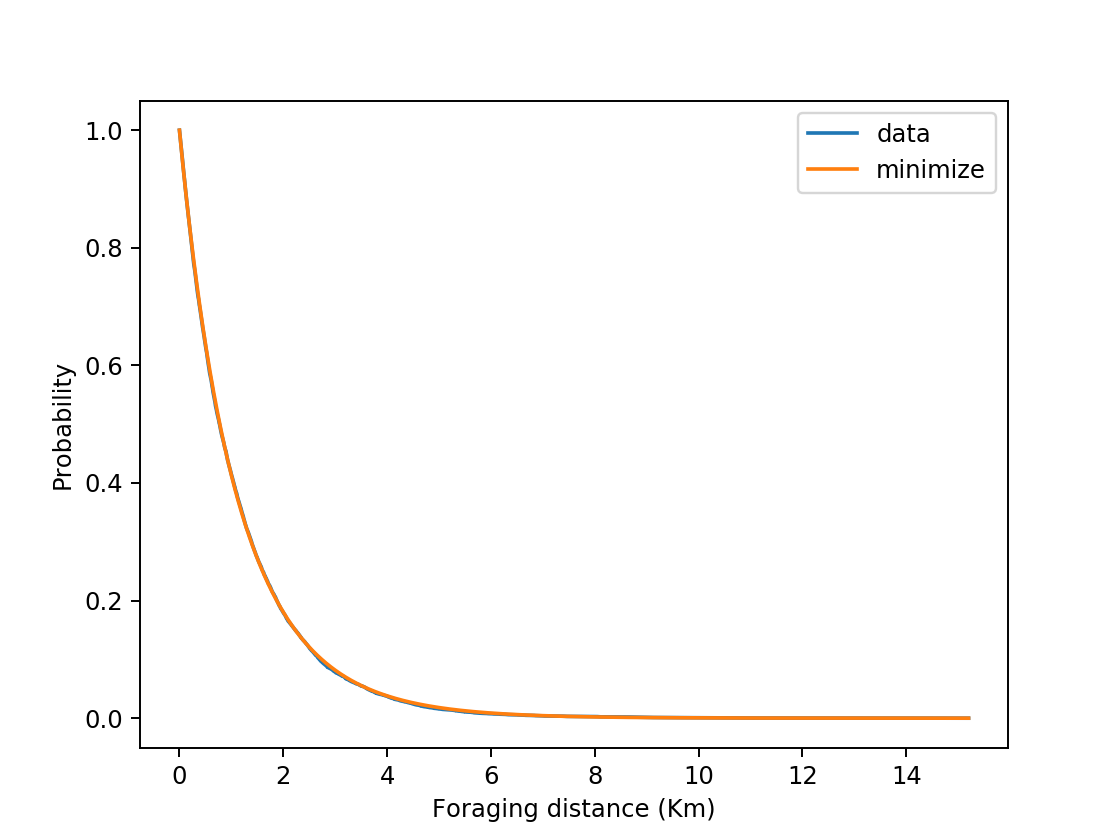

<IPython.core.display.Javascript object>


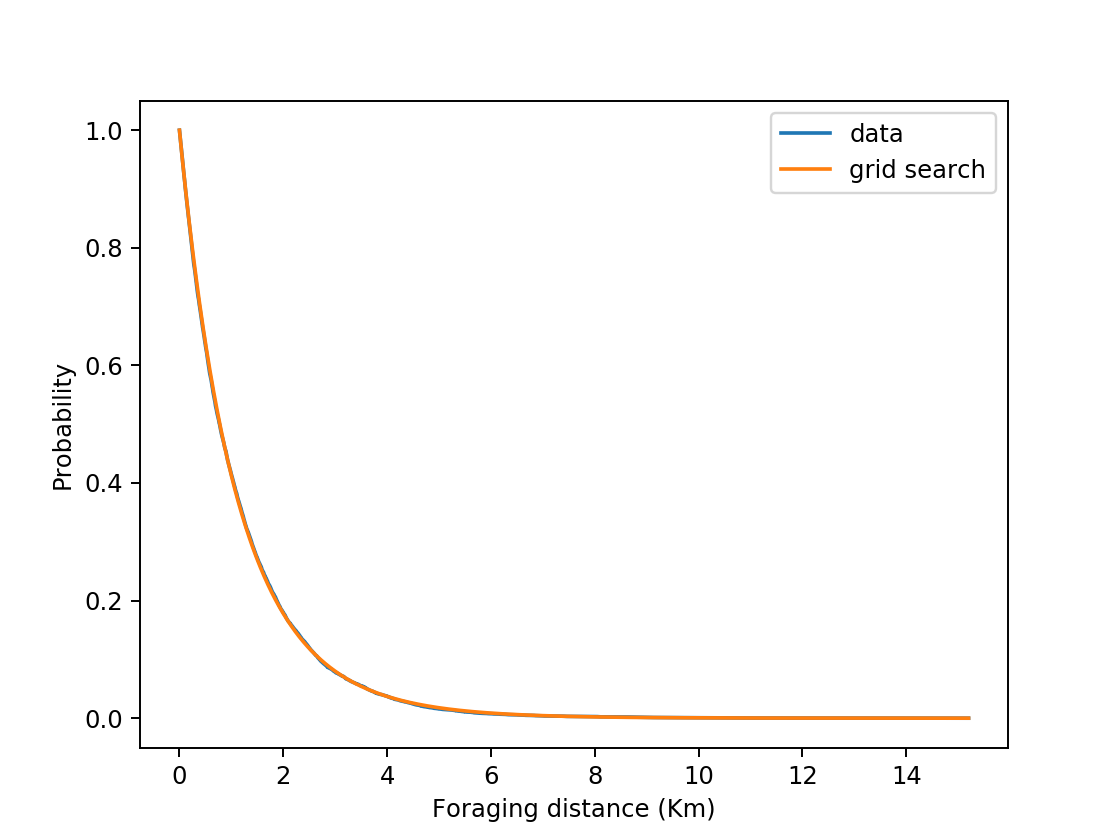

<module 'matplotlib.pyplot' from '/home/joe/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [236]:
simdata = simdata.flatten()

# figure from minimize
predict_fig(simdata, model.x, cdf_func, "minimize",
                           "Foraging distance (Km)",
                           "Probability")

inparams = [1.2910362377100586, 0.8926545807940686, 0.6067446941362831, 0.20408163, 0.57142857]
predict_fig(simdata, inparams, cdf_func, "grid search",
                           "Foraging distance (Km)",
                           "Probability")

The above figures show the actual data generated from simulating using known paramaters (blue line) along with the data generated from the paramaters for highest log-likelihood (orange line) identified from minimized (top figure) and grid search routines (bottom figure).

This plot demonstrates that although the maximisation routine is returning different paramaters to those used in sampling, the model is as good. This suggests different paramater combinations can produce the same or similar data. It is notable, however, that the likelihood for the paramaters used to simulate the data is -11786, where as the optimised likelihood is -11526, a difference of 260 with a sample size of 10,000. This difference is likely down to the model fitting to the random variations in the data, suggesting the model could be over fitting.

When the rate paramaters are fixed the actual values give a likelihood of -11786 where as the optimiser finds values with a likelihood of -11526. This is the exact same scores as when the rate paramaters are not fixed, a difference of 260 with a sample size of 10,000.

Whilst the actual paramater values and those with the highest likelihood are not exactly the same, this is likely due to random variations in the data. When the rate values are not fixed however, these values change along with the weighting values to produce the same likelihood as to when the rates are fixed. The fact the values are different to those used in simulation could be either an effect of using weights, allowing multiple different paramater combinations that produce the same distribution shape, or evidence of the model overfitting to random variations in the data (or a combination of both, question is why is the grid search and the minimizer producing better paramater estimates than those used with such a large ammount of data? This looks to me like it is over fitting). 

Tidy this block up and extend for more paramaters using the minimization routine. 

You should also go over the above statement and back it up at relevent sections of the document.
 